In [1]:
%pylab inline
%load_ext Cython

import pyximport; pyximport.install(setup_args={"include_dirs":numpy.get_include()})
import paramless as pmain
import paramless_cython as pm

Populating the interactive namespace from numpy and matplotlib


### Testing 2D 

In [ ]:
domain = np.array([np.arange(0.001, 1.0, 0.01), np.arange(0.001, 1.0, 0.01)])
initial_surface = np.ones_like(np.outer(domain[0], domain[1]))
mutator = pm.nDimGaussianMutator(.1, domain, 0.1)
#mutated = mutator.do_mutation(initial_surface.reshape(-1))
mutated = mutator.helper(5050)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')
x, y = np.meshgrid(domain[0], domain[1])
surf = ax.plot_surface(x, y, mutated.reshape((len(domain[0]),len(domain[1]))) ,cmap=cm.coolwarm)
ax.set_zlim(-0.1, 0.1)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

In [ ]:
print(mutated)

### Testing 1D 

In [ ]:
domain = np.array([np.arange(0.001, 1.0, 0.01)])
initial_surface = np.ones_like(domain)
mutator = pm.nDimGaussianMutator(.01, domain, 0.1)
#mutated = mutator.doMutation(initial_surface.reshape(-1))
mutated = mutator.helper(50)

In [ ]:
plot(domain[0], mutated)

In [ ]:
%%cython
import numpy as np
cimport numpy as np
from numpy.math cimport INFINITY
from libc.stdlib cimport rand, srand, RAND_MAX
from libc.math cimport exp

cdef int MAX_ITERATIONS = 1000000

cdef class nDimGaussianMutator:
    """ A Mutator implementation for use in mutating the entire vector according to a Gaussian distribution """
    # The epsilon to be used in mutations, the width of the distribution and
    # absolute bounds for resulting vectors
    cdef double mutation_epsilon, width, lower_bound, upper_bound
    # The domain of the vectors to be used and the number of points in each dimension
    # points variable allows for domain to be 1 dimensional
    cdef double[:] domain
    cdef long[:] points

    def __init__(self, double mutation_epsilon, np.ndarray[double, ndim=1] domain, double width,
                 np.ndarray[long, ndim=1] points, double lower_bound=INFINITY, double upper_bound=-INFINITY):
        self.mutation_epsilon = mutation_epsilon
        self.domain = domain
        self.width = width
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.points = points

    cdef double[:] cyDoMutation(self, double[:] vector):
        """ The Cython code used to mutate the given vector.

        Args:
            vector: the vector to be mutated

        Returns:
            A point mutated vector
        """
        cdef int is_inside = 0
        cdef int attempt = 0
        cdef double[:] mutant
        while (is_inside != 1):
            mutant = self.attempt_gaussian_mutation(vector)
            is_inside = cy_within_bounds(
                mutant, self.lower_bound, self.upper_bound)
            attempt += 1
            if attempt > MAX_ITERATIONS:
                raise RuntimeError(
                    "Attempted too many mutations without producing anything within bounds")
        return mutant

    def doMutation(self, np.ndarray[double, ndim=1] vector):
        """ A wrapper function to allow Python code to access the optimised Cython code. """
        return np.asarray(self.cyDoMutation(vector))

    cdef double[:] attempt_gaussian_mutation(self, double[:] vector):
        """ The body of the mutation code. Mutation is completed through randomly choosing a point
            in the vector and a width and increasing or decreasing its value and the surrounding values according
            to a Gaussian distribution multiplied by the mutation epsilon.

        Args:
            vector: The vector to be mutated

        Returns:
            The mutated vector        
        """
        cdef int index = int(rand() / float(RAND_MAX) * vector.shape[0])
        cdef double[:] mutant = np.copy(vector)
        cdef double[:] perturbation = self.helper(index)
        cdef int i, size = mutant.shape[0]
        # upwards
        if (rand() % 2):
            for i in range(size):
                mutant[i] += perturbation[i]
        # downwards
        else:
            for i in range(size):
                mutant[i] -= perturbation[i]
        return mutant

    cdef double[:] helper(self, int value):
        """ The helper function tasked with creating an array representing a Gaussian distribution centred
            on the given value.

        Args:
            value: The centre of the distribution.

        Returns:
            A memoryview representing a Gaussian distribution.
        """
        cdef double[:] result = np.zeros(self.points).reshape(-1)
        cdef double adj_width = self.width * rand() / float(RAND_MAX)
        cdef int i, size = np.prod(self.points)
        cdef np.ndarray[double, ndim = 1] vals, centre = self.get_vals(self.get_coords(value))
        for i in range(size):
            vals = self.get_vals(self.get_coords(i))
            result[i] = self.mutation_epsilon * exp(-np.linalg.norm(vals - centre)**2 / adj_width)
        return result
    
    cdef np.ndarray[int, ndim=1] get_coords(self, int num):
        cdef np.ndarray[int, ndim=1] coord = np.zeros(self.points.shape[0], dtype=np.int).reshape(-1)
        for i, size in enumerate(self.points):
            coord[i] = num % size
            num //= size
        return coord
                                                                           
    cdef np.ndarray[double, ndim=1] get_vals(self, np.ndarray[int, ndim=1] coords):
        return np.array([self.domain[x + sum(self.points[:i])] for i, x in enumerate(coords)])
                                                                        
                                                                           

cdef int cy_within_bounds(double[:] vector, double lower, double upper):
    """ Checks if a vector is within the given bounds.
        Cython funciton.

    Args:
        vector: The vector to be checked
        lower: The lower bound
        upper: The upper bound

    Returns:
        1 if vector is within the bounds, 0 otherwise
    """
    cdef double mn = vector[0], mx = vector[0]
    cdef int i, size = vector.shape[0]
    for i in range(size):
        if vector[i] < mn:
            mn = vector[i]
        if vector[i] > mx:
            mx = vector[i]
    if lower != INFINITY and mn < lower:
        return 0
    if upper != -INFINITY and mx > upper:
        return 0
    return 1


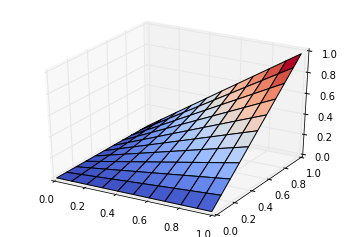

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.arange(0, 1, .01)
y = np.copy(x)
target = np.outer(x, y)
x, y = np.meshgrid(x, y)
surf = ax.plot_surface(x, y, target, cmap=cm.coolwarm)

In [21]:
x = np.arange(0, 1, .01)
y = np.copy(x)
domain = np.array([x, y])

initial_surface = np.zeros_like(target)
fitness_function = pm.DistanceFitnessFunction(target.reshape(-1))
mutator = pm.nDimGaussianMutator(0.05, domain, 0.1)
evolver = pm.StandardEvolver(fitness_function, mutator, 1e-12)

In [ ]:
x = np.arange(0, 10, 1.)
y = np.copy(x)
domain = np.array([x, y])

initial_surface = np.zeros_like(target)
fitness_function = pm.DistanceFitnessFunction(target.reshape(-1))
mutator = pm.PointMutator(0.0001)
evolver = pm.StandardEvolver(fitness_function, mutator, 1e-12)

In [4]:
from collections import OrderedDict as OrderedDict

def evolve(initial_surface, evolver, iterations, return_time_series=False, seed=None):
    """
    The main evolve function

    Args:
        initial_surface: An array containing the initial surface for use in the evolution
        evolver: An Evolver object implementing a do_step(resident) method
        iterations: The number of iterations to be performed
        return_time_series: Whether this function will return a time series of residents
        seed: The seed to be used for the random number generator

    Returns:
        The final resident and, if requested, the time series data formatted as an OrderedDict
    """
    np.random.seed(seed)
    time_series = None
    last_entry_time = 0
    resident = np.copy(initial_surface)
    seq = 0
    if return_time_series:
        time_series = OrderedDict()
    previous_resident = np.zeros_like(initial_surface)
    for step in range(1, iterations):
        if return_time_series:
            previous_resident = np.copy(resident)
        shape = resident.shape
        resident, invasion = evolver.do_step(resident.reshape(-1))
        resident = resident.reshape(shape)
        if (return_time_series and invasion):
            time_series[seq] = {
                "alive": step - last_entry_time, "resident": previous_resident}
            last_entry_time = step
            seq += 1
    if return_time_series:
        return resident, time_series
    else:
        return resident

In [24]:
ans = evolve(initial_surface, evolver, iterations=100, return_time_series=False, seed=777)

In [25]:
print(fitness_function.get(ans.reshape(-1)))
print(fitness_function.get(initial_surface.reshape(-1)))

0.00035415010777830637
0.00040812162024283155


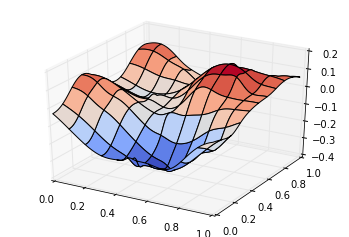

In [26]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
x = domain[0]
y = domain[1]
x, y = np.meshgrid(x, y)
surf = ax.plot_surface(x, y, ans,cmap=cm.coolwarm)

In [ ]:
print(ans.shape)
print(x.shape)
print(y.shape)

## Let's try 1D

In [ ]:
domain = np.linspace(-1.0, 1.0, 1000)  
target = sin(domain*domain*domain)


initial_surface = np.zeros_like(target)
iterations= 10000
mutator = pm.GaussianMutator(0.01, domain, 0.05)
fitness_function = pm.DistanceFitnessFunction(target)
evolver = pm.StandardEvolver(fitness_function, mutator, 1e-12)
ans_sin, series_sin = evolve(initial_surface, evolver, iterations=iterations, return_time_series=True, seed=777)

plot(domain, ans_sin)

In [ ]:
plot(domain, target)